In [6]:
# IMPORT PACKAGES
from pydantic import BaseModel, Field
from typing import Annotated, List
from langchain_core.messages import BaseMessage
from langchain_tavily import TavilySearch
from dotenv import load_dotenv
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langchain_core.prompts import PromptTemplate
import numexpr
import math
from langchain_experimental.utilities import PythonREPL
from typing import Literal
from langgraph.types import Command
from langchain_community.tools import WikipediaQueryRun

from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import DuckDuckGoSearchRun


from typing import Literal
from langgraph.graph import END
from langchain_core.output_parsers import PydanticOutputParser
import re
import json

load_dotenv()

True

## AGENT STATE


In [7]:
# AGENT STATE
class AgentState(BaseModel):
    messages: Annotated[List[BaseMessage], Field(default= [], description= "The messages in the state")]
    
    tools_sender: Annotated[Literal["coder", "maths_reasoner", "researcher", None], Field(default= None, description= "Which node has used this tool latest")]
    
    used_tools: Annotated[bool, Field(default= None, description= "Whether the tools have been used in this state or not in the very last step")]



## TOOLS

In [8]:

# TOOL1: TAVILY WEB SEARCH
tavily_search = TavilySearch(
    max_results=5,
    topic="general"
)

@tool
def web_search_tool(query: str) -> str:
    """
    Perform a web search for the given query and return relevant information.

    This tool is useful for retrieving up-to-date facts, summaries, or context 
    from the internet when the agent lacks sufficient knowledge. Ideal for 
    questions about recent events, uncommon topics, or external data.
    """
    
    return tavily_search.invoke(query)

In [9]:
# TOOL 2: PYTHON REPL

python_repl = PythonREPL()

@tool
def python_code_executor_tool(query: str) -> str:
    """
    Executes the provided Python code and returns the output.

    Useful for performing calculations, data transformations, or 
    evaluating logic during reasoning tasks. Accepts code snippets 
    as input and returns either the result or any error messages encountered.
    """
        
    return python_repl.run(query)

In [10]:
# TOOL 3: WIKIPEDIA
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

@tool
def wikipedia_search_tool(query: str) -> str:
    """
    Searches Wikipedia for the given query and returns a summary of the most relevant information.

    Useful for retrieving general knowledge, historical facts, definitions, or topic overviews
    from a reliable encyclopedic source.
    """
        
    return wikipedia.run(query)

In [11]:
# TOOL 4: DUCK DUCK GO SEARCH

duck_search = DuckDuckGoSearchRun()

@tool
def duck_duck_search_tool(query: str) -> str:
    """
    Performs a web search using DuckDuckGo and returns relevant results.

    Useful for retrieving real-time or general web-based information, especially when 
    up-to-date data, diverse sources, or alternative viewpoints are needed.
    """
    
    
    return duck_search.invoke(query)


In [12]:
# TOOL 5: PUB MED

from langchain_community.tools.pubmed.tool import PubmedQueryRun

pubmed = PubmedQueryRun()

@tool
def pubmed_search_tool(query: str) -> str:
    """
    Searches PubMed for scholarly articles related to the given query and returns a summary of the results.

    Useful for retrieving peer-reviewed biomedical and life sciences research, including clinical studies, 
    reviews, and scientific publications from trusted academic sources.
    """
    
    return pubmed.invoke(query)

In [13]:
# TOOL 6: CALCULATOR

@tool
def calculator(expression: str) -> str:
    """
    Evaluate a mathematical expression using Python's numexpr library.

    This tool is designed for:
      • Fast and safe evaluation of arithmetic and algebraic expressions
      • Handling large numeric computations efficiently
      • Supporting common mathematical operators ( +, -, *, /, **, (), etc. )

    Parameters
    ----------
    expression : str
        A single-line valid mathematical expression written in Pythonic syntax.
        No variables or multi-line logic are allowed.

        Examples:
            "37593 * 67"        — for multiplication
            "37593**(1/5)"      — for fifth root
            "sqrt(49) + 3*5"    — for compound expressions

    Returns
    -------
    str
        The numeric result of the evaluated expression as a string.
        If the expression is invalid or unsafe, an appropriate error message is returned.
    """

    local_dict = {"pi": math.pi, "e": math.e}
    return str(
        numexpr.evaluate(
            expression.strip(),
            global_dict={},  # restrict access to globals
            local_dict=local_dict,  # add common mathematical functions
        )
    )

## CREATE THE TOOLS ARSERNAL

In [14]:
# CREATE THE TOOLS ARSERNAL
tools_arsenal= [web_search_tool, wikipedia_search_tool, duck_duck_search_tool, pubmed_search_tool, python_code_executor_tool, calculator]

tools_arsenal_lookup= {tool.name: tool for tool in tools_arsenal}




In [15]:
# LLM
# llm_model= ChatGroq(
#     model= "llama-3.3-70b-versatile"
# )
import os
load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY_2")
# Use any Groq-supported model you have access to
llm_model = ChatGroq(
    groq_api_key=groq_api_key,
    model="llama-3.1-8b-instant",   # pick a model you actually have access to
    temperature=0,
)



# bind llm with tools
binded_llm_model= llm_model.bind_tools(tools= tools_arsenal)


In [16]:
# SUPERVISOR PYDANTIC PARSER CLASS
class SupervisorOutput(BaseModel):
    """
    Output schema for the supervisor agent that decides which specialist to activate next 
    in a multi-agent workflow.
    """
    
    route: Annotated[Literal["enhancer", "greeting", "coder", "maths_reasoner", "researcher"], Field(default= ..., description= "Specifies which specialist agent should be activated next based on the user's query or task context.")]
    

In [17]:
# NODES CONSTANTS
SUPERVISOR= "supervisor"
ENHANCER= "enhancer"
GREETING= "greeting"
CODER= "coder"
MATHS_REASONER= "maths_reasoner"
RESEARCHER= "researcher"
# VALIDATOR= "validator"
SHOULD_USE_TOOLS= "should_use_tools"
TOOLS= "tools"

## NODES GENERATION

In [18]:
# NODE 1: SUPERVISOR NODE
def supervisor_node(state: AgentState) -> Command[Literal["enhancer", "greeting", "researcher", "coder", "maths_reasoner"]]:
    
    # parser
    pyd_parser= PydanticOutputParser(pydantic_object= SupervisorOutput)
    
    # prompt template
    prompt_temp= PromptTemplate(template= """
You are a supervisor agent responsible for routing tasks to the appropriate specialist agent
based on the content and intent of the conversation.

Your task is to carefully analyze the given messages and decide which of the following 
specialist agents should handle the task next:

  - enhancer: improves or reformulates text
  - coder: writes or debugs code
  - greeting: basic conversational / user-relationship manager
  - maths_reasoner: performs mathematical problem solving or reasoning
  - researcher: gathers factual or external knowledge through search


Messages:
{messages}


You must return ONLY a valid JSON object, no extra commentary. The format is:

{format_instructions}
                                """,
    input_variables= ["messages"],
    partial_variables= {
        "format_instructions": pyd_parser.get_format_instructions()
    }                          
)
    
    
    # chain
    chain= prompt_temp | llm_model | pyd_parser
    
    
    # invoke the chain
    chain_output= chain.invoke({
        "messages": state.messages[-4:]
    })
    
    
    return Command(
        goto= chain_output.route
    )

In [19]:
# NODE 2: GREETING NODE

def greeting_node(state: AgentState) -> Command[Literal["__end__"]]:
    """
    Greeting agent node that welcomes the user, establishes a friendly and professional tone,
    and sets up the interaction for downstream agents.
    """
    
    # prompt template
    greeting_prompt = PromptTemplate(
    template="""
You are a **Conversational Establisher Agent**, responsible for initiating the interaction with the user,
making them feel welcomed and understood, while gently steering the conversation towards identifying their core objective.

Your duties:
1. Start with a warm, professional greeting.
2. Express readiness to help, showing empathy and domain awareness.
3. Encourage the user to describe what they need help with — even if vaguely.
4. End with a confident statement that you’ll pass this to the appropriate specialist to assist further.

Constraints:
- Keep the tone friendly, supportive, and confident.
- Avoid asking any questions — assume the user has already shared their message.
- Do not repeat or paraphrase the user's message.
- Focus on building rapport and setting the stage for the next agent.

---

Messages: {messages}
""",
    input_variables=["messages"]
)
    
    
    # chain
    chain= greeting_prompt | llm_model
    
    # invoke chain
    chain_output_content= chain.invoke({
        "messages": state.messages[-4:]
    })

    
    # update the state
    state.messages+= [chain_output_content]
    
    return Command(
        goto= END,
        
        update= state
    )

In [20]:
# NODE 3: ENHANCER NODE

def enhancer_node(state: AgentState) -> Command[Literal["supervisor"]]:
    """
        Enhancer agent node that improves and clarifies user queries.
        Takes the original user input and transforms it into a more precise,
        actionable request before passing it to the supervisor.
    """
    
    # prompt template
    query_refiner_prompt = PromptTemplate(
    template="""
You are a **Query Refinement Specialist**, an expert in transforming vague, incomplete, or ambiguous user requests into clear, complete, and executable task instructions.

Your responsibilities include:
1. Carefully analyzing the original query to identify the core intent and specific requirements.
2. Resolving any ambiguity by applying domain knowledge and reasonable assumptions — do not ask the user follow-up questions.
3. Expanding underdeveloped areas of the query with helpful context and inferred details where necessary.
4. Rewriting the query in a way that is clear, concise, logically structured, and ready for downstream processing (e.g., by an AI agent, search system, or code generator).
5. Ensuring that any technical or domain-specific terminology is properly explained or contextualized when appropriate.

Important constraints:
- Do **not** ask the user any clarifying questions.
- Do **not** echo or repeat the original query unnecessarily.
- Your output must be a refined, self-contained version of the user's intent that enables immediate action.

---

Messages: {messages}
""",
    input_variables=["messages"]
)
    
    
    # chain
    chain= query_refiner_prompt | llm_model
    
    # invoke chain
    chain_output_content= chain.invoke({
        "messages": state.messages[-4:]
    })

    
    # update the state
    state.messages+= [chain_output_content]
    
    return Command(
        goto= SUPERVISOR,
        
        update= state
    )

In [21]:
# NODE 4: SHOULD USE TOOLS NODE
    
def should_use_tools_node(state: AgentState) -> Command[Literal["tools", "__end__"]]:
    
    # get the last ai msg
    last_ai_msg= state.messages[-1]
    
    
    if hasattr(last_ai_msg, "tool_calls") and len(last_ai_msg.tool_calls) > 0 and not state.used_tools:
        
        # tools req.
        return Command(
            goto= TOOLS
        )
    
    
    else:
        
        # update state
        state.used_tools= False
        state.tools_sender= None
        
        return Command(
            goto= END,
            update= state
        )

In [22]:
# TOOL 5: USE TOOLS NODE

def use_tools_node(state: AgentState) -> Command[Literal["coder", "maths_reasoner", "researcher"]]:
    
    all_tool_msgs= []
    
    # get the last ai msg
    last_msg= state.messages[-1]
    
    for tc in last_msg.tool_calls:
        
        tool_msg= tools_arsenal_lookup[tc["name"]].invoke(tc)
        
        all_tool_msgs.append(tool_msg)
        
    # update the state
    state.messages+= all_tool_msgs
    state.used_tools= True
    
    return Command(
            goto= state.tools_sender,
            update= state
        )

In [23]:
# NODE 6: CODER NODE
def coder_node(state: AgentState) -> Command[Literal["should_use_tools"]]:


  # Prompt template for the LLM
    prompt_template = PromptTemplate(
        template="""
You are an expert Python developer and quantitative analyst.

Your task:
  • Write clean, efficient Python **code** that fully solves the problem described below.
  • Add concise inline comments to explain the logic and any mathematical operations.
  • If the task involves mathematics, use appropriate libraries (e.g., sympy, numpy) and
    print the final numeric or symbolic result.
  • If the task involves data or visualisation, use pandas/matplotlib and display or save
    the figure.
  • Output **only** a single Python code block—nothing else.


---

Messages: {messages}

# -------  Begin your Python code below  -------
""",
        input_variables=["messages"],
    )
    
    if state.used_tools:
        # use tools wala llm
        chain= prompt_template | llm_model
        
    else:
        
        chain= prompt_template | binded_llm_model
        
    
    # invoke chain
    ai_msg= chain.invoke({
        "messages": state.messages[-4:]
    })

    
    # update the state
    state.messages+= [ai_msg]
    state.tools_sender= "coder"
    
    return Command(
          goto= SHOULD_USE_TOOLS,
          update= state
      )

In [24]:
# NODE 7: MATHS REASONER NODE
def maths_reasoner_node(state: AgentState) -> Command[Literal["should_use_tools"]]:

    # Prompt template for the LLM

    prompt_template = PromptTemplate(
        template="""
You are a highly intelligent mathematical problem solver and a master of logical reasoning.

You are expected to solve **either** a mathematical question, a logical reasoning task, or a combination of both. Follow the steps below based on the nature of the problem:

---

📌 **For Mathematical Problems:**
- Carefully read and understand the problem.
- Show step-by-step working, including all relevant formulas and justifications.
- Use symbolic manipulation where needed (e.g., algebra, calculus, equations).
- If code is required (e.g., for evaluation or plotting), generate minimal, functional Python code.
- End your solution with the final result clearly stated as:

---

🧠 **For Reasoning or Analytical Problems:**
- Break the problem down logically and sequentially.
- State any assumptions or interpretations clearly.
- Use deductive or inductive reasoning to arrive at a conclusion.
- Explain your thought process in a structured way (e.g., bullet points or paragraphs).
- Finish your response by stating the final conclusion as:


---

Messages: {messages}
""",
        input_variables=["messages"],
    )

    
    
    if state.used_tools:
        # use tools wala llm
        chain= prompt_template | llm_model
        
    else:
        
        chain= prompt_template | binded_llm_model
    
    # invoke chain
    ai_msg= chain.invoke({
        "messages": state.messages[-4:]
    })

    
    # update the state
    state.messages+= [ai_msg]
    state.tools_sender= "maths_reasoner"
    
    return Command(
        goto= SHOULD_USE_TOOLS,
        update= state
    )

In [25]:
# NODE 8: RESEARCHER NODE
def researcher_node(state: AgentState) -> Command[Literal["should_use_tools"]]:
    """
        Research agent node that gathers information using Web search using Tavily, Wikipedia search, Duck Duck go search, PubMed search.
        Takes the current task state, performs relevant research,
        and returns findings for validation.
    """
   
    
   # prompt template
    prompt_template= PromptTemplate(template= 
"""You are an **Information Specialist** with deep expertise in performing thorough, factual, and objective research across a wide range of topics.

Your primary responsibility is to act as a high-precision information retriever. Given a query, your job is not to speculate, analyze, or solve — but to gather, organize, and present the most relevant and up-to-date information available.

Your responsibilities include:
1. **Understanding the Information Need**  
   Carefully examine the user’s query to determine what kind of information is being requested — factual data, definitions, background context, recent developments, statistics, or comparisons.

2. **Retrieving Trusted Information**  
   Search for accurate and credible information from authoritative, up-to-date sources (e.g., academic articles, trusted websites, official databases). If no reliable information is available, clearly state that instead of speculating.

3. **Presenting Results Clearly**  
   Organize the gathered information in a clear, structured, and readable format. Use bullet points, headings, or short paragraphs to improve readability.

4. **Maintaining Objectivity and Relevance**  
   Stick to factual reporting. Do not analyze, interpret, or solve the problem — your role is strictly to **gather and present** information without introducing personal conclusions or assumptions.

Constraints:
- ❌ Do **not** provide opinions, speculative statements, or suggested actions.
- ❌ Do **not** attempt to solve the problem or write code — focus solely on information retrieval.
- ✅ Be concise but complete in your findings.
- ✅ If relevant information cannot be found, say so clearly.

---

Messages: {messages}

""",

input_variables= ["messages"])
    
    
       # get the last role before the update
    
    
    if state.used_tools:
        # use tools wala llm
        chain= prompt_template | llm_model
        
    else:
        
        chain= prompt_template | binded_llm_model
    
    # invoke chain
    ai_msg= chain.invoke({
        "messages": state.messages[-4:]
    })

    
    # update the state
    state.messages+= [ai_msg]
    state.tools_sender= "researcher"
    
    return Command(
        goto= SHOULD_USE_TOOLS,
        update= state
    )

In [26]:
from langgraph.graph import StateGraph
from dotenv import load_dotenv


from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver

import asyncio

import logging

# Silence only the internal LangGraph noise
logging.getLogger("langgraph").setLevel(logging.ERROR)
logging.getLogger("langgraph.pregel").setLevel(logging.ERROR)


In [47]:
# GRAPH CONSTANTS 

graph= StateGraph(AgentState)

memory= MemorySaver()

LLM= "llm"
TOOLS= "tools"


# ADD NODES -> GRAPH
graph.add_node("enhancer", enhancer_node)
graph.add_node("greeting", greeting_node)

graph.add_node("coder", coder_node)
graph.add_node("maths_reasoner", maths_reasoner_node)
graph.add_node("researcher", researcher_node)

graph.add_node("should_use_tools", should_use_tools_node)
graph.add_node("tools", use_tools_node)

graph.add_node("supervisor", supervisor_node)

graph.set_entry_point("supervisor")

In [48]:
app= graph.compile(checkpointer= memory)

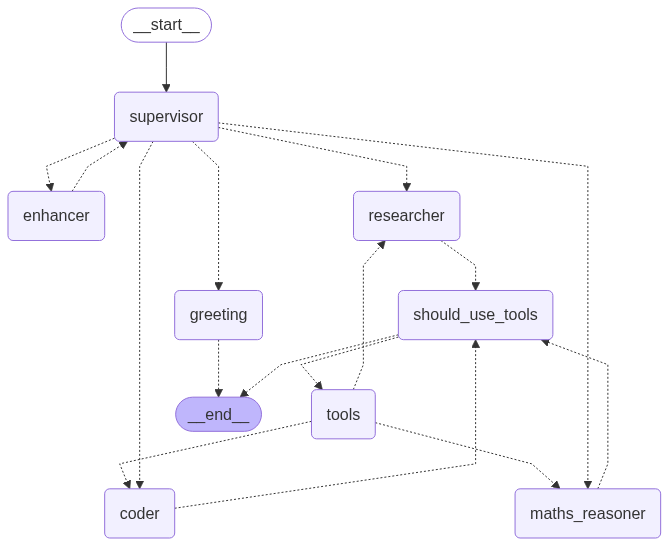

In [49]:
from IPython.display import display, Image

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [44]:
# memory configuration
memory_config = {
    "configurable": {
        "thread_id": 2
    }
}

# take user prompt
user_prompt = 'twhat is attention mechanism?'

if user_prompt.lower() == "q":
    print("Exiting the application.")
    exit(0)

# Get saved memory
snapshot = app.get_state(config=memory_config)

if snapshot and "messages" in snapshot.values:
    old_msgs = snapshot.values["messages"]
else:
    old_msgs = []

# invoke the agent
events = app.astream_events(
    input=AgentState(messages=old_msgs + [HumanMessage(content=user_prompt)]),
    version="v2",
    config=memory_config
)

# show the ai response
print(f"\nAI: ", end="", flush=True)

async for event in events:
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="", flush=True)



AI: {"route": "researcher"}**Attention Mechanism in Deep Learning**

The attention mechanism is a method used in deep learning to determine the importance of each component in a sequence relative to the other components in that sequence. In natural language processing, importance is represented by "soft" weights assigned to each word in a sentence.

**Key Concepts:**

1. **Attention weights**: Soft weights assigned to each word in a sentence to represent its importance.
2. **Query, Key, and Value**: These are the three main components of the attention mechanism. The query is used to compute the attention weights, the key is used to compute the attention scores, and the value is used to compute the output.
3. **Softmax**: A function used to normalize the attention scores to obtain the attention weights.
4. **Transformer**: A type of neural network architecture that uses the attention mechanism to handle sequential data.

**Applications:**

1. **Machine Translation**: The attention mech

In [55]:
# memory configuration
memory_config = {
    "configurable": {
        "thread_id": 8
    }
}

# take user prompt
user_prompt = 'who is virat kohli?'

if user_prompt.lower() == "q":
    print("Exiting the application.")
    exit(0)

# Get saved memory
snapshot = app.get_state(config=memory_config)

if snapshot and "messages" in snapshot.values:
    old_msgs = snapshot.values["messages"]
else:
    old_msgs = []

# invoke the agent
events = app.astream_events(
    input=AgentState(messages=old_msgs + [HumanMessage(content=user_prompt)]),
    version="v2",
    config=memory_config
)

# show the ai response
print(f"\nAI: ", end="", flush=True)

async for event in events:
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="", flush=True)



AI: {"route": "researcher"}**Information Retrieval for Virat Kohli**

**Understanding the Information Need**

The user's query is about Virat Kohli, an Indian international cricketer. The information need is to gather factual data about his cricket career, including his achievements, records, and notable events.

**Retrieving Trusted Information**

Based on the tool calls, the following information has been retrieved:

1. **Wikipedia Search Tool**: The tool call with ID '4fx7wzc28' retrieved information about Virat Kohli from Wikipedia, including his biography, cricket career, and achievements.
2. **Wikipedia Search Tool**: The tool call with ID 'sd1nqeara' retrieved information about Virat Kohli's biography from Wikipedia.
3. **Web Search Tool**: The tool call with ID 'nw5qcenpy' retrieved information about Virat Kohli's cricket career from various online sources, including Wikipedia, MyKhel, Britannica, and India Today.

**Presenting Results Clearly**

Here is the organized informat

In [57]:
# memory configuration
memory_config = {
    "configurable": {
        "thread_id": 29
    }
}

# take user prompt
user_prompt = 'what is the value of  (8.8-8.11) ?'

if user_prompt.lower() == "q":
    print("Exiting the application.")
    exit(0)

# Get saved memory
snapshot = app.get_state(config=memory_config)

if snapshot and "messages" in snapshot.values:
    old_msgs = snapshot.values["messages"]
else:
    old_msgs = []

# invoke the agent
events = app.astream_events(
    input=AgentState(messages=old_msgs + [HumanMessage(content=user_prompt)]),
    version="v2",
    config=memory_config
)

# show the ai response
print(f"\nAI: ", end="", flush=True)

async for event in events:
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="", flush=True)



AI: {"route": "maths_reasoner"}Based on the provided messages, it appears that we have a mathematical problem to solve. The problem is to find the value of (8.8 - 8.11).

To solve this problem, we will follow the steps outlined in the instructions.

**Step 1: Understand the problem**

The problem is to find the value of the expression (8.8 - 8.11).

**Step 2: Show step-by-step working**

To find the value of the expression, we will simply subtract 8.11 from 8.8.

8.8 - 8.11 = ?

**Step 3: Use symbolic manipulation**

We can use the calculator tool to evaluate the expression.

```python
result = 8.8 - 8.11
print(result)
```

**Step 4: Generate minimal, functional Python code**

The code above is the minimal, functional Python code required to evaluate the expression.

**Step 5: End with the final result**

---

The final result is: **0.6900000000000013**


AI: {"route": "coder"}

Python REPL can execute arbitrary code. Use with caution.


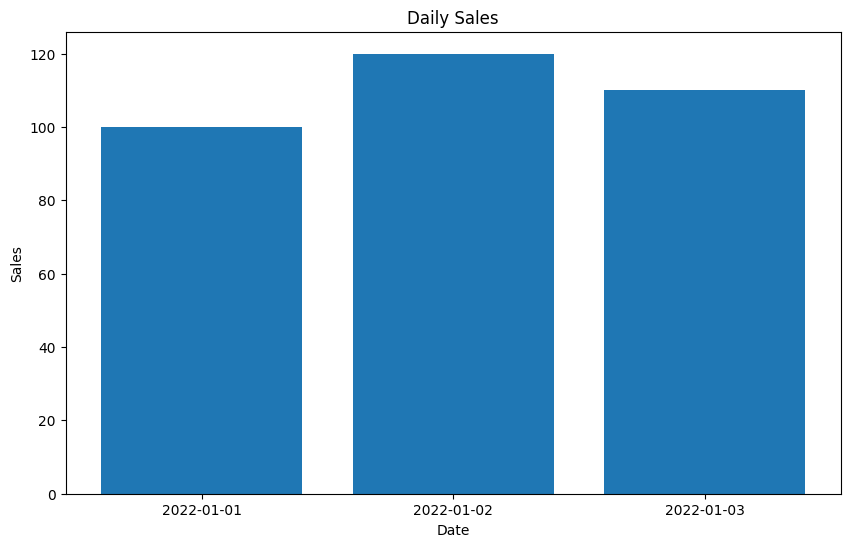

```python
import matplotlib.pyplot as plt
import pandas as pd

# Sample data
sales_data = pd.DataFrame({
    'Date': ['2022-01-01', '2022-01-02', '2022-01-03'],
    'Sales': [100, 120, 110]
})

# Create a bar chart
plt.figure(figsize=(10,6))
plt.bar(sales_data['Date'], sales_data['Sales'])  # Plot bars for each date
plt.xlabel('Date')  # Set x-axis label
plt.ylabel('Sales')  # Set y-axis label
plt.title('Daily Sales')  # Set chart title

# Show the plot
plt.show()
```

In [59]:
# memory configuration
memory_config = {
    "configurable": {
        "thread_id": 45
    }
}

# take user prompt
user_prompt = 'i want the code to generate bar chart given date and sales columns?'

if user_prompt.lower() == "q":
    print("Exiting the application.")
    exit(0)

# Get saved memory
snapshot = app.get_state(config=memory_config)

if snapshot and "messages" in snapshot.values:
    old_msgs = snapshot.values["messages"]
else:
    old_msgs = []

# invoke the agent
events = app.astream_events(
    input=AgentState(messages=old_msgs + [HumanMessage(content=user_prompt)]),
    version="v2",
    config=memory_config
)

# show the ai response
print(f"\nAI: ", end="", flush=True)

async for event in events:
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="", flush=True)
